In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)



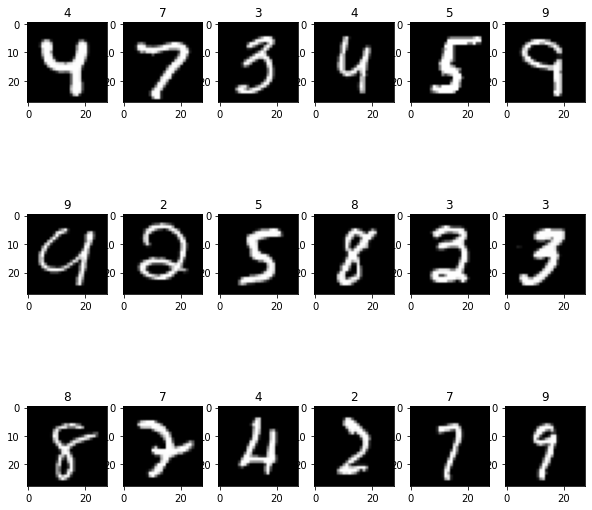

In [3]:
# look at some figures from the trainin_data:

figure = plt.figure(figsize=(10, 10))
rows, cols = 3, 6
for i in range(1,cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis=("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [82]:
import torchvision.transforms as TT
from pathlib import Path

multi_images_path = Path("multi_images/")
multi_images_path.mkdir()

# initialization of random generator:
g_cpu = torch.Generator()
g_cpu.manual_seed(2147483647)

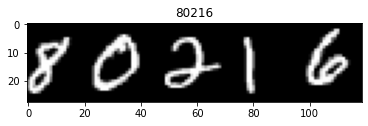

In [94]:
# number of figures/cifers in the generated number:
nof_cifers = 5

crop_height = 28
crop_images = []
labels = []
merge_points = []
merge_point = 0
for i in range(nof_cifers):
    # chose random image:
    sample_id = torch.randint(nof_images, size=(1,), dtype=torch.int32, generator=g_cpu).item()
    img, label = training_data[sample_id]
    labels.append(label)
    # chose random clipping parameters:
    crop_left = torch.randint(8, size=(1,), dtype=torch.int32, generator=g_cpu)
    crop_width = torch.randint(20, 28, size=(1,), dtype= torch.int32, generator=g_cpu)
    crpimg= TT.functional.crop(img, top=0, left=crop_left, height=crop_height, width=crop_width)
    # store clipped images for later merging:
    crop_images.append(crpimg)
    # store x-coordinate of merge-point:
    merge_point = merge_point + crop_width.item()
    merge_points.append(merge_point)
    #plt.imshow(crpimg.squeeze(), cmap="gray")

multi_img = torch.cat(crop_images, dim = 2)
multi_img_label = "".join([str(j) for j in labels]) 
multi_img_name = multi_img_label + ".jpg"
m_img = TT.ToPILImage()(multi_img)
m_img.save(multi_images_path / multi_img_name )
#C:\Users\BoSc\Documents\9999_Public_Repository_Github\BSC Public Github\multi_digit_MNIST\data

# show multi-digit-image:
plt.title(multi_img_label)
plt.imshow(multi_img.squeeze(), cmap="gray")


multi_img.shape: torch.Size([1, 28, 112])


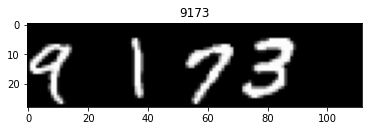

In [103]:
"""
    Glues Mnist-Image data fo 28 X 28 images to a multi-figure number.
    The width of the images is randomly clipped before glueing to make it more alike a real hand written multi-cifer number.
    Input:
        nof_cifers : number of figures in the output number
        data : torch.dataset containing (image, label) - pairs
    returns :
        multi_img : a torch tensor of the image of the glued numbers - size: [1, 28, nof_cifers X 28]
        multi_img_label : a torch.int32 number glued from the individual labels
        merge_points : a list of integers giving the x-coordinates of the points where the MNIST numbers where glued
"""
def merge_MNIST(data, nof_cifers=2):

    # check for some bogus input:
    #if nof_cifers == 1:
    #    return data[0], data[1], [data[0].shape[1]]

    #if len(data) == 1:
    #    return data[0][0], data[0[1], [data[0][0].shape[1]]
    
    #if nof_cifers > len(data):
    #    return data[0][0], data[0[1], [data[0][0].shape[1]]
    
    crop_height = 28
    crop_images = []
    labels = []
    merge_points = []
    merge_point = 0
    for i in range(nof_cifers):
        # chose random image:
        sample_id = torch.randint(nof_images, size=(1,), dtype=torch.int32, generator=g_cpu).item()
        img, label = data[sample_id]
        labels.append(label)
        # chose random clipping parameters:
        crop_left = torch.randint(8, size=(1,), dtype=torch.int32, generator=g_cpu)
        crop_width = torch.randint(20, 28, size=(1,), dtype= torch.int32, generator=g_cpu)
        crpimg= TT.functional.crop(img, top=0, left=crop_left, height=crop_height, width=crop_width)
        # store clipped images for later merging:
        crop_images.append(crpimg)
        # store x-coordinate of merge-point:
        merge_point = merge_point + crop_width.item()
        merge_points.append(merge_point)
        #plt.imshow(crpimg.squeeze(), cmap="gray")
    
    # fill image with black space to full dimensions:
    black_fill = torch.zeros([1,28, nof_cifers * 28 - merge_points[-1]])
    crop_images.append(black_fill)
    multi_img = torch.cat(crop_images, dim = 2)
    multi_img_label = "".join([str(j) for j in labels])

    return multi_img, multi_img_label, merge_points





multi_img.shape: torch.Size([1, 28, 140])


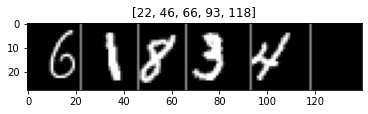

In [126]:
# check the points, where the images are merged ("merge_points"), by drawing a grey vertical line:

from PIL import ImageDraw

multi_img, multi_img_label, merge_points = merge_MNIST(training_data, nof_cifers=5)
im = TT.ToPILImage()(multi_img)
draw = ImageDraw.Draw(im)
for mp in merge_points:
    draw.line([(mp, 0), (mp, 28)], width=1, fill=128)
plt.title(merge_points)
plt.imshow(im, cmap="gray")

In [129]:
# Write 1000 samples into folder:
# names of the files are the merge_points.
import torchvision.transforms as TT
from pathlib import Path, PureWindowsPath

def write_multi_records(target_directory, number_of_cifers, mumber_of_records):
    target_dir = Path(target_directory)
    target_dir.mkdir(exist_ok=True)
    nof_cifers = number_of_cifers

    # Write 1000 samples into folder:
    for i in range(mumber_of_records):
        multi_img, multi_img_label, merge_points = merge_MNIST(training_data, nof_cifers=4)
        multi_record = { 
            "multi_img": multi_img, 
            "multi_img_label" : multi_img_label, 
            "merge_points" : merge_points 
        }
        # filename example: "1234" + "_26_48_75_97" + ".pt" 
        multi_name = "".join([str(j) for j in multi_img_label]) + "_" + "_".join([str(mp) for mp in merge_points]) + ".pt"
        torch.save(multi_record, target_dir / multi_name)

In [135]:
# load example:
mr = torch.load("Mnist4/0029_24_51_78_101.pt")
mr

{'multi_img': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'multi_img_label': '0029',
 'merge_points': [24, 51, 78, 101]}

In [123]:
multi_name

'3610_22_48_71_96.pt'